# k Nearest Neighbour

In [141]:
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from util import data_utils

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# import autoreload
# ?autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
cifar10_root = 'util/datasets/cifar-10-batches-py'
data = data_utils.load_CIFAR10(cifar10_root)

In [2]:
# store data in train and test
Xtrain, ytrain, Xtest, ytest = data
def shape(*args):
    for item in args:
        print(item.shape)
shape(Xtrain)

NameError: name 'data' is not defined

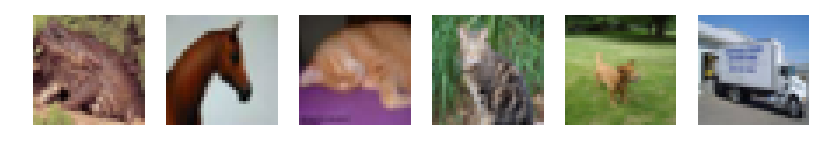

In [75]:
# vizualize the CIFAR images
num_samples = 6
random_idx = np.random.choice(Xtrain.shape[0], num_samples)

for i, idx in enumerate(random_idx):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(Xtrain[idx].astype('uint8'))
    plt.axis('off')

In [76]:
# sample the data for easy training
sample_size = 5000
mask = range(sample_size)

Xtrain = Xtrain[mask]
ytrain = ytrain[mask]

sample_size = 500
mask = range(sample_size)
Xtest = Xtest[mask]
ytest = ytest[mask]

# reshape each image into single vector
Xtrain = Xtrain.reshape(Xtrain.shape[0], -1)
Xtest = Xtest.reshape(Xtest.shape[0], -1)
# shape()

### Classification

In [131]:
from classifiers import k_nearest_neighbor
classifiers = k_nearest_neighbor.KNearestNeighbour()
classifiers.train(Xtrain, ytrain)

Compute distance between each test example and training example.

In [132]:
# dists = classifiers.distance_two_loops(Xtest)
dists = classifiers.distance_no_loop(Xtest)
dists.shape

(500, 5000)

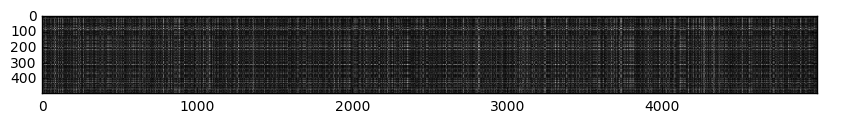

In [133]:
# vix distance matrix
plt.imshow(dists, interpolation='none')
plt.show()

Train class: 4
Test class: 1


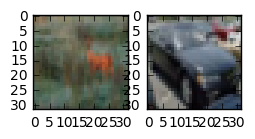

In [134]:
def check_similar(test_num):
    # find most similar image to test_num
    train_num = np.argmin(dists[test_num])
    plt.subplot(1, 7, 1)
    plt.imshow(Xtrain[train_num].reshape(data[0][0].shape).astype('uint8'))
    print("Train class:", ytrain[train_num])

    plt.subplot(1, 7, 2)
    plt.imshow(Xtest[test_num].reshape(data[0][0].shape).astype('uint8'))
    print("Test class:", ytest[test_num])
    

check_similar(np.random.choice(Xtest.shape[0]))

### Compute accuracy

In [186]:
def accuracy(y, ypred):
    correct_classified = np.sum(ypred == y)
    return 100*correct_classified/y.shape

In [140]:
ypred = classifiers.predict(dists, K=1)
print("Accuracy = {}%".format(accuracy(ytest, ypred)[0]))

ypred = classifiers.predict(dists, K=5)
print("Accuracy = {}%".format(accuracy(ytest, ypred)[0]))

Accuracy = 27.4%
Accuracy = 28.4%


In [18]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

In [78]:
two_loop = time_function(classifiers.distance_two_loops, Xtest)
print("Two loop time: {}sec".format(two_loop))

one_loop = time_function(classifiers.distance_one_loop, Xtest)
print("One loop time: {}sec".format(one_loop))

no_loop = time_function(classifiers.distance_no_loop, Xtest)
print("One loop time: {}sec".format(no_loop))

Two loop time: 28.415384769439697sec
One loop time: 29.252327919006348sec
One loop time: 0.4327874183654785sec


### Cross Validation
Use cross validatio to select the best hyper-parameter, K

In [173]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(Xtrain, num_folds)
y_train_folds = np.array_split(ytrain, num_folds)

k_to_accuracies = defaultdict(list)
for num_fold in range(num_folds):
    X = np.vstack(X_train_folds[:num_fold] + X_train_folds[num_fold+1:])
    y = np.hstack(y_train_folds[:num_fold] + y_train_folds[num_fold+1:])
    classifiers.train(X, y)
    
    Xval = X_train_folds[num_fold]
    yval = y_train_folds[num_fold]
    for k in k_choices:
        dist = classifiers.distance_no_loop(Xval)
        ypred = classifiers.predict(dist, K=k)
        k_to_accuracies[k].append(accuracy(yval, ypred)[0])
        

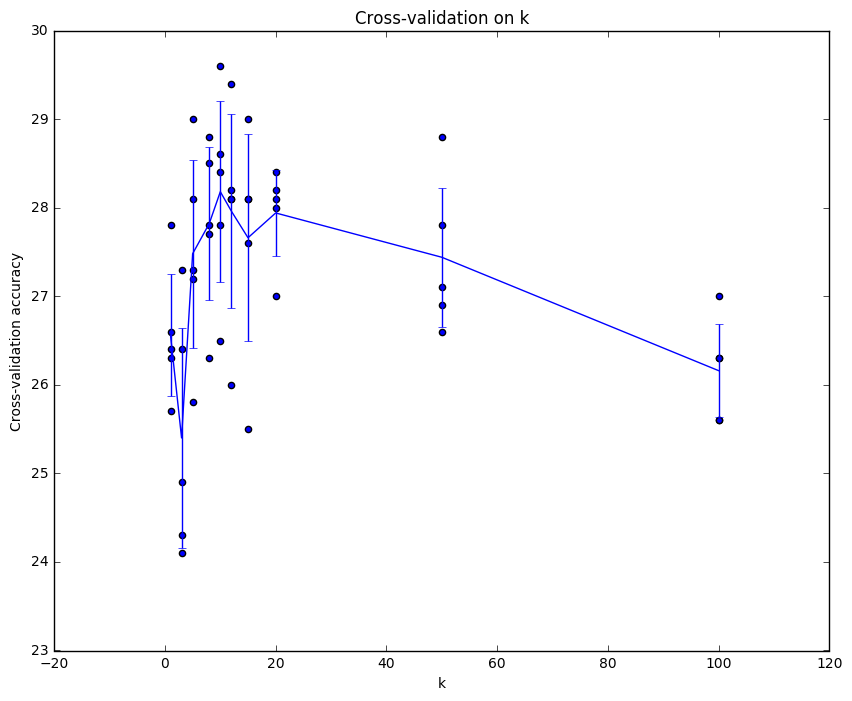

In [185]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [191]:
best_k = 5

classifiers.train(Xtrain, ytrain)
dist = classifiers.distance_no_loop(Xtest)
ypred = classifiers.predict(dist, K=best_k)

print("Accuracy = {}%".format(accuracy(ytest, ypred)[0]))

Accuracy = 28.4%
